In [1]:
import os
import sys
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random
import math
import warnings
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 19
random.seed = seed
np.random.seed = seed

Instructions for updating:
non-resource variables are not supported in the long term


/home/sd/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
IMG_WIDTH = 384
IMG_HEIGHT = 384
IMG_CHANNELS = 3

TRAIN_PATH = '/home/sd/zsq_python/YOLO/stage1_train'
TEST_PATH = '/home/sd/zsq_python/YOLO/stage1_test'

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

train_images = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [4]:
# Resize train images.
print('resize train images... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + "/" + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    train_images[n] = img
    
# Get and resize test images
sizes_test = []
print('resize test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + "/" + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test_images[n] = img

print('Done!')

resize train images... 


100%|██████████| 670/670 [00:26<00:00, 25.06it/s]

resize test images ... 



100%|██████████| 65/65 [00:02<00:00, 24.22it/s]

Done!


In [5]:
def store_bounding_boxes(img, train_id, mask_id, rotby_90):
    ret, thresh = cv2.threshold(img, 127, 255, 0)
    contours = cv2.findContours(thresh.astype(np.uint8), 1, 2)
    cnt = contours[0]
        
    x, y, w, h = cv2.boundingRect(cnt)    
    
    x = x * (IMG_WIDTH/img.shape[1])
    w = w * (IMG_WIDTH/img.shape[1])
    y = y * (IMG_WIDTH/img.shape[0])
    h = h * (IMG_WIDTH/img.shape[0])
    
    if(x > IMG_WIDTH-1):
        x = IMG_WIDTH-1
    if(y > IMG_HEIGHT-1):
        y = IMG_HEIGHT-1
    if(x+w > IMG_WIDTH-1):
        w = IMG_WIDTH-1 - x
    if(y+h > IMG_HEIGHT-1):
        h = IMG_HEIGHT-1 - y
        
    bbdict = { "train_id": train_id, "mask_id": mask_id, "rotby_90": rotby_90, "x": x, "y": y, "w": w, "h": h}
    return bbdict

In [6]:
path_bboxes_csv = "/home/sd/zsq_python/YOLO/bboxes.csv"
if not os.path.isfile(path_bboxes_csv):
    bboxes = pd.DataFrame(columns=["train_id", "mask_id", "rotby_90", "x", "y", "w", "h"])
    row_count = 1
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + "/" + id_
        for mask_id, mask_file in enumerate(next(os.walk(path + '/masks/'))[2]):
            mask_ = imread(path + '/masks/' + mask_file)
            for r in range(4):
                bboxes.loc[row_count] = store_bounding_boxes(np.rot90(mask_, r), id_, mask_id, r)
                row_count += 1
    bboxes.to_csv(path_bboxes_csv, index=False)
else:
    bboxes = pd.read_csv(path_bboxes_csv)

In [7]:
GRID_DIM = 12
GRID_PIX = IMG_WIDTH//GRID_DIM
BATCH_SIZE = 14

In [8]:
train_ids_df = pd.DataFrame(columns=["idx", "id_"])
cnt = 0
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    train_ids_df.loc[cnt] = { "idx": n, "id_": id_}
    cnt += 1

train_ids_df = train_ids_df.set_index(['idx'])

100%|██████████| 670/670 [00:03<00:00, 200.01it/s]


In [9]:
bboxes['grid_row'] = bboxes['y']//GRID_PIX
bboxes['grid_column'] = bboxes['x']//GRID_PIX

bboxes['grid_center_x'] = bboxes['grid_column'] * GRID_PIX + GRID_PIX/2
bboxes['grid_center_y'] = bboxes['grid_row'] * GRID_PIX + GRID_PIX/2

bboxes['box_center_x'] = bboxes.x + bboxes['w']/2
bboxes['box_center_y'] = bboxes.y + bboxes['h']/2

bboxes['new_x'] = (bboxes.box_center_x - bboxes.grid_center_x)/(IMG_WIDTH)
bboxes['new_y'] = (bboxes.box_center_y - bboxes.grid_center_y)/(IMG_HEIGHT)

bboxes['new_w'] = np.sqrt(bboxes.w/(IMG_WIDTH))
bboxes['new_h'] = np.sqrt(bboxes.h/(IMG_WIDTH))

bboxes['confidence'] = 1

bboxes['box_area'] = bboxes.new_w*bboxes.new_h

In [10]:
mask_count = 1
#Set maximum bounding boxes allowed per grid cell
MAX_BB_CNT = 2

In [11]:
def get_grid_info(tr_id, rotby_90):
    df = bboxes.loc[(bboxes.train_id == tr_id) & (bboxes.rotby_90 == rotby_90), 'grid_row':'box_area']
    df.drop(['grid_center_x', 'grid_center_y','box_center_x', 'box_center_y',], axis = 1, inplace=True)
    df = df.sort_values(['grid_column', 'grid_row', 'box_area'], ascending=False)
    #print(len(df))
    global mask_count
    mask_count += len(df)
    label_info = np.zeros(shape=(GRID_DIM, GRID_DIM, MAX_BB_CNT, 5),  dtype=np.float32) + 0.000001
    
    for ind, row in df.iterrows():
        i = int(row[0])
        j = int(row[1])
        for b in range(MAX_BB_CNT):
            if(label_info[i, j, b][4] != 1.0):
                label_info[i, j, b] = np.array(row[2:7])
                break
    return label_info

In [12]:
def get_labels(counts, rotations):
    grid_info = np.zeros(shape=(BATCH_SIZE, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5), dtype=np.float32)
    for i, c in enumerate(counts):
        tr_id = train_ids_df.loc[c, 'id_']
        grid_info[i] = get_grid_info(tr_id, rotations[i])
    grid_info = np.reshape(grid_info, newshape=[BATCH_SIZE, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
    return grid_info

In [13]:
def get_images(counts, rotations):
    images = np.zeros(shape=(BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
    for i, c in enumerate(counts):
        images[i] = np.rot90(train_images[c], rotations[i])
    return images

In [14]:
def next_batch():
    rotations = []
    rand_counts = []
    for i in range(BATCH_SIZE):
        rotations.append(random.randint(0, 3))
        rand_counts.append(random.randint(0, 669))
    return get_images(rand_counts, rotations), get_labels(rand_counts, rotations)

In [15]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, IMG_WIDTH, IMG_HEIGHT, 3])
Y_ = tf.placeholder(tf.float32, [None, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
lr = tf.placeholder(tf.float32)

In [16]:
def process_logits(logits, name=None):
    net = tf.reshape(logits, [-1, GRID_DIM*1, GRID_DIM*1, MAX_BB_CNT*5*16, 1])
    net = tf.layers.average_pooling3d(net, [1, 1, 16], [1, 1, 16], padding="valid")

    net = tf.reshape(net, [-1, GRID_DIM*GRID_DIM*MAX_BB_CNT, 5]) #GRID_DIM = 12
    net = tf.transpose(net, [1, 2, 0])        

    logits_tensor = tf.map_fn(lambda x:
                            tf.stack([
                                tf.tanh(x[0]),
                                tf.tanh(x[1]),
                                tf.sqrt(tf.sigmoid(x[2])),
                                tf.sqrt(tf.sigmoid(x[3])),
                                tf.sigmoid(x[4])
                            ]), net)

    logits_tensor = tf.transpose(logits_tensor, [2, 0, 1])
    logits_tensor = tf.reshape(logits_tensor, [-1, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])

    return logits_tensor

In [17]:
def normalize_yolo_loss(processed_logits, lambda_coords, lambda_noobj):
    yolo_loss = tf.reduce_sum(tf.squared_difference(labels, processed_logits), axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)

    yolo_loss = tf.stack([tf.multiply(lambda_coords, yolo_loss[0]), 
                          tf.multiply(lambda_coords, yolo_loss[1]),
                          yolo_loss[2],
                          yolo_loss[3],
                          tf.multiply(lambda_noobj,yolo_loss[4])])
    yolo_loss = tf.reduce_sum(yolo_loss)

    return  yolo_loss

In [18]:
def l_relu(features):
    return tf.nn.leaky_relu(features, 0.1)

In [19]:
# Below code need optimization may be by using Variable Scope.
def squeeze_module(x, dim, idx):
    name = 'conv_' + idx + '_sq'
    return tf.layers.conv2d(x, filters=dim, kernel_size=1, strides=1, padding="same", 
                           activation=l_relu, name=name)

def expand_module(x, dim, idx):
    name = 'conv_' + idx + '_ex_' + '0'
    net1 = tf.layers.conv2d(x, filters=dim, kernel_size=1, strides=1, padding="same", 
                           activation=l_relu, name=name)
    name = 'conv_' + idx + '_ex_' + '1'
    net2 = tf.layers.conv2d(x, filters=dim, kernel_size=3, strides=1, padding="same", 
                           activation=l_relu, name=name) 
    return tf.concat([net1, net2], 3)

In [20]:
def fire_module(input_tensor, squeeze_dim, expand_dim, idx):
    net = squeeze_module(input_tensor, squeeze_dim, idx)
    net = expand_module(net, expand_dim, idx)
    return net

In [21]:
# Below code need optimization may be by using Variable Scope.

net = tf.layers.conv2d(X, filters=32, kernel_size=1, strides=1, padding="same", 
                       activation=l_relu, name='conv0') #384 

net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #192

net = fire_module(net, 32, 64, '0')
net = fire_module(net, 32, 64, '1')
net = fire_module(net, 32, 64, '2')

net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #96


net = fire_module(net, 64, 96, '3')
net = fire_module(net, 64, 96, '4')
net = fire_module(net, 64, 96, '5')


net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #48

net = fire_module(net, 128, 160, '6')
net = fire_module(net, 128, 160, '7') 
net = fire_module(net, 128, 128, '8')


net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #24

net = fire_module(net, 256, 512, '9')
net = fire_module(net, 256, 512, '10')
net = fire_module(net, 256, 512, '11')

net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #12

net = fire_module(net, 512, 1024, '12')
net = fire_module(net, 512, 1024, '13')
net = fire_module(net, 512, 1024, '14')

logits = tf.layers.conv2d(net, filters=MAX_BB_CNT*5*16, kernel_size=1, strides=1, padding="same",
                       activation=None, name='conv40') #12

processed_logits = process_logits(logits)

labels = Y_

lambda_coords = tf.constant(5.0)
lambda_noobj = tf.constant(0.5)

yolo_loss = normalize_yolo_loss(processed_logits, lambda_coords, lambda_noobj)

train_op = tf.train.AdamOptimizer(lr).minimize(yolo_loss)

/home/sd/.local/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
/home/sd/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/home/sd/.local/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/pooling.py:310: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  warnings.warn('`tf.layers.max_pooling2d` is deprecated and '
/home/sd/.local/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/pooling.py:388: UserWarning: `tf.lay

In [22]:
start_training = False #using pretrained model as Kaggle server doesn't allow training time more than 6 hrs.
if not start_training:
    test_image_id = 33
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, "/home/sd/zsq_python/YOLO/model/model.ckpt")
        result = sess.run([processed_logits], {X: np.reshape(test_images[test_image_id], [1, 384, 384, 3])})

INFO:tensorflow:Restoring parameters from /home/sd/zsq_python/YOLO/model/model.ckpt


In [23]:
if(start_training):
    # initialize
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    batch_count = 0
    display_count = 1
    global mask_count

    for i in range(33000):
        batch_X, batch_Y = next_batch()
        batch_count += 1
        train_loss, _ = sess.run([yolo_loss, train_op], {X: batch_X, Y_: batch_Y, lr: 0.0001})

        if(i % 100 == 0):
            print(str(display_count) + " training loss(" + str(mask_count) + "): " + str(train_loss))
            display_count +=1
        mask_count = 0
    print("Done!")
if(start_training):
    test_image_id = 14
    result = sess.run([processed_logits], {X: np.reshape(test_images[test_image_id], [1, 384, 384, 3])})
boxes = result[0]
print(boxes.shape)
boxes = np.reshape(boxes, newshape=[GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
bbs = []

for i in range(GRID_DIM):
    for j in range(GRID_DIM):
        for b in range(MAX_BB_CNT):
            if(boxes[i][j][b][4]> 0.1):
                grid_center_x = ((j+0)*GRID_PIX + GRID_PIX/2)
                grid_center_y = ((i+0)*GRID_PIX + GRID_PIX/2)
                
                new_box_center_x = boxes[i][j][b][0] * IMG_WIDTH + grid_center_x
                new_box_center_y = boxes[i][j][b][1] * IMG_HEIGHT + grid_center_y

                new_w = np.square(boxes[i][j][b][2]) * IMG_WIDTH
                new_h = np.square(boxes[i][j][b][3]) * IMG_HEIGHT
                
                x1 = new_box_center_x - new_w/2
                y1 = new_box_center_y - new_h/2

                x2 = new_box_center_x + new_w/2
                y2 = new_box_center_y + new_h/2

                bbs.append((math.floor(x1), math.floor(y1), math.ceil(x2), math.ceil(y2)))

(1, 12, 12, 2, 5)


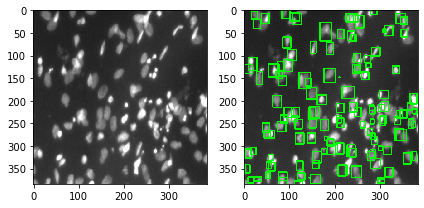

In [24]:
img = test_images[test_image_id]
f, axs = plt.subplots(1,2)
axs[0].imshow(img)

imshow(img)
for i, b in enumerate(bbs):
    cv2.rectangle(img,(b[0], b[1]),(b[2], b[3]),(0,255,0),2)

axs[1].imshow(img)